In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from collections import Counter
from pet_document import PetDocument

In [2]:
df = pd.read_parquet("./assets/pet_dataset.parquet")

In [3]:
def generate_simple_bar_chart(values, categories, xLabel, yLabel, title):
    # Set the width of the bars
    bar_width = 0.35

    # Set the positions of the bars on the x-axis
    bar_positions = np.arange(len(categories))

    # Calculate the dynamic figure width based on the number of categories
    figure_width = max(10, len(categories) * 0.8)

    # Set the figure size dynamically
    plt.figure(figsize=(figure_width, 6))  # Adjust the height as needed

    # Create the bar plot
    plt.bar(bar_positions, values, width=bar_width)

    # Add labels and title
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    plt.title(title)
    plt.xticks(bar_positions, categories)

    for i, value in enumerate(values):
        plt.text(bar_positions[i], value + 0.1, str(value), ha="center", va="bottom")

    # Display the plot
    plt.show()

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def generate_horizontal_bar_chart(values, categories, xLabel, yLabel, title):
    # Set the height of the bars
    bar_height = 0.35

    # Set the positions of the bars on the y-axis
    bar_positions = np.arange(len(categories))

    # Calculate the dynamic figure height based on the number of categories
    figure_height = max(6, len(categories) * 0.8)

    # Set the figure size dynamically
    plt.figure(figsize=(10, figure_height))  # Adjust the width as needed

    # Create the horizontal bar plot
    plt.barh(bar_positions, values, height=bar_height)

    # Add labels and title
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    plt.title(title)
    plt.yticks(bar_positions, categories)

    for i, value in enumerate(values):
        plt.text(value + 0.1, bar_positions[i], str(value), ha="left", va="center")

    # Display the plot
    plt.show()

In [5]:
# Convert to objects
pet_documents = df.to_dict(orient="records")
records = []
# TODO: Refactor
for document in pet_documents:
    converted_document = PetDocument(
        name=document["document name"],
        tokens=document["tokens"],
        tokens_ids=document["tokens-IDs"],
        ner_tags=document["ner_tags"],
        sentence_ids=document["sentence-IDs"],
    )
    converted_document.relations["source_head_sentence_id"] = document[
        "relations.source-head-sentence-ID"
    ]
    converted_document.relations["source_head_word_id"] = document[
        "relations.source-head-word-ID"
    ]
    converted_document.relations["relation_type"] = document["relations.relation-type"]
    converted_document.relations["target_head_sentence_id"] = document[
        "relations.target-head-sentence-ID"
    ]
    converted_document.relations["target_head_word_id"] = document[
        "relations.target-head-word-ID"
    ]
    records.append(converted_document)

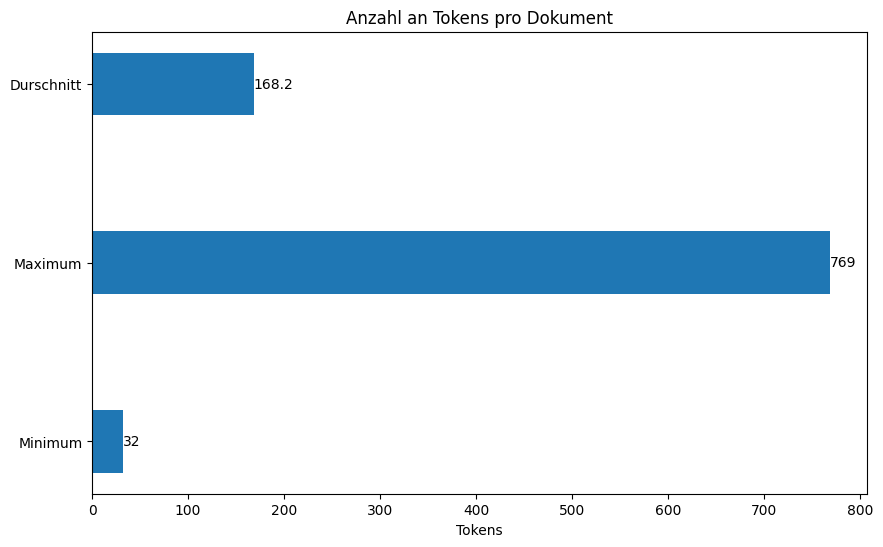

In [6]:
total_tokens = 0
for record in records:
    total_tokens += len(record.tokens)

def get_lengths(documents):
    result = []
    for document in documents:
        result.append(len(document.tokens))
    return result


min_tokens = min(get_lengths(records))
max_tokens = max(get_lengths(records))
avg_tokens = total_tokens / len(records)

generate_horizontal_bar_chart(
    values=[min_tokens, max_tokens, avg_tokens], 
    categories=["Minimum", "Maximum", "Durschnitt"], 
    xLabel="Tokens", 
    yLabel="", 
    title="Anzahl an Tokens pro Dokument"
)

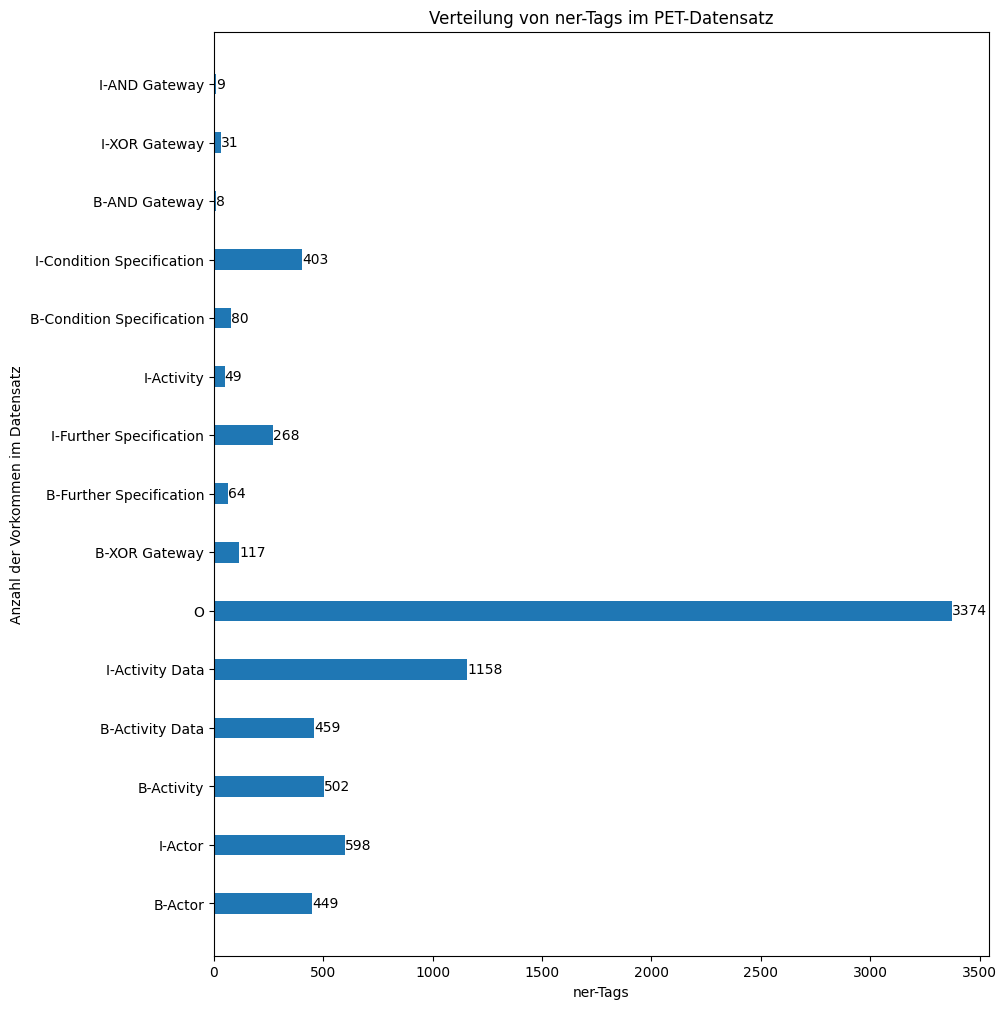

In [7]:
ner_tags = []
for record in records:
    ner_tags.extend(record.ner_tags)

ner_tags_counts = Counter(ner_tags)

plot_categories = []
plot_values = []

for string, count in ner_tags_counts.items():
    plot_categories.append(string)
    plot_values.append(count)

generate_horizontal_bar_chart(
    values=plot_values, 
    categories=plot_categories, 
    xLabel="ner-Tags", 
    yLabel="Anzahl der Vorkommen im Datensatz", 
    title="Verteilung von ner-Tags im PET-Datensatz"
)

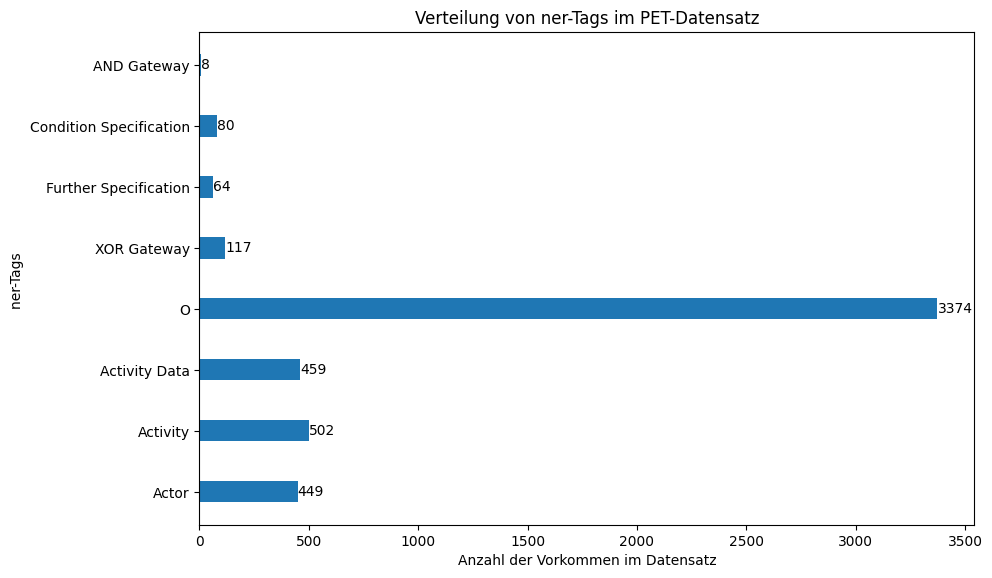

In [27]:
filtered_ner_tags = []
plot_categories = []
plot_values = []

for item in ner_tags_counts.items():
    if not item[0].startswith("I"):
        filtered_ner_tags.append(item)

for tag, count in filtered_ner_tags:
    plot_categories.append(tag.replace("B-", ""))
    plot_values.append(count)

generate_horizontal_bar_chart(
    values=plot_values, 
    categories=plot_categories, 
    xLabel="Anzahl der Vorkommen im Datensatz", 
    yLabel="ner-Tags ", 
    title="Verteilung von ner-Tags im PET-Datensatz"
)

In [8]:
# Generate HTML
with open('assets/template.html', 'r') as file:
    html_template = file.read()

data = ""

for record in records:
    html_content = html_template
    html_content = html_content.replace("<!-- TITLE -->", record.name)
    for token, ner_tag in zip(record.tokens, record.ner_tags):
        data += f"<span class='{ner_tag}'>{token}</span>"
    html_content = html_content.replace("<!-- CONTENT  -->", data)
    with open(f"out/{record.name}.html", 'w') as file:
        file.write(html_content)

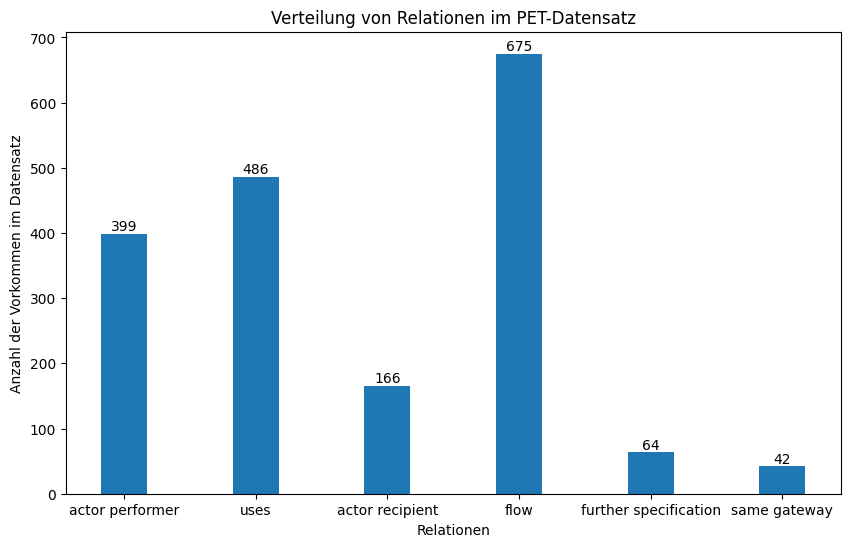

In [9]:
relations = []
for record in records:
    relations.extend(record.relations["relation_type"])

relations_counts = Counter(relations)

plot_categories = []
plot_values = []

for string, count in relations_counts.items():
    plot_categories.append(string)
    plot_values.append(count)

generate_simple_bar_chart(
    values=plot_values, 
    categories=plot_categories, 
    xLabel="Relationen", 
    yLabel="Anzahl der Vorkommen im Datensatz", 
    title="Verteilung von Relationen im PET-Datensatz"
)